In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import kde
import datetime
import time
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Càrrega de les dades de Nova York 

In [2]:
start = time.time() 
nyc_crime = pd.read_csv('https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv')
print ("Descarregant dades...")
print ("Temps de descàrrega {} sec\n".format(time.time() - start))
print ("Carregades les dades de Nova York,", len(nyc_crime), "registres")

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Descarregant dades...
Temps de descàrrega 521.1653189659119 sec

Carregades les dades de Nova York, 7309655 registres


## Estudi de les dades i pre-processat

In [3]:
print (nyc_crime.head())
print (nyc_crime.describe())
for col in nyc_crime.columns: 
    print (col, len(nyc_crime[col].unique()), nyc_crime[col].dtype)

   CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
0   876525802   04/10/2008     19:10:00          NaN          NaN   
1   402693528   06/03/2007     15:23:00          NaN          NaN   
2   832030069   02/16/2010     20:50:00   02/16/2010     20:50:00   
3   538308771   11/10/2009     16:35:00   11/10/2009     16:45:00   
4   965693192   04/11/2006     09:30:00   04/11/2006     10:00:00   

   ADDR_PCT_CD      RPT_DT  KY_CD          OFNS_DESC  PD_CD   ...   SUSP_SEX  \
0         73.0  04/10/2008    341      PETIT LARCENY  321.0   ...        NaN   
1         28.0  06/03/2007    236  DANGEROUS WEAPONS  782.0   ...        NaN   
2        102.0  02/16/2010    105            ROBBERY  375.0   ...        NaN   
3         79.0  11/10/2009    341      PETIT LARCENY  333.0   ...        NaN   
4        123.0  04/25/2006    112        THEFT-FRAUD  739.0   ...        NaN   

  TRANSIT_DISTRICT   Latitude  Longitude                        Lat_Lon  \
0              NaN  40.669414

## Descripció dels camps

https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

<ul>
    <li>'CMPLNT_NUM': És l'identificador de cada cas, les dades són de tipus int64, per tant, serà útil per identificar cada registre </li>
    <li>'CMPLNT_FR_DT': La data d'inici què han passat o s'estima que han passat els fets. Cal transformar-ho a format de data i també s'extrauran altres variables relacionades amb la data. </li>
    <li>'CMPLNT_FR_TM': L'hora d'inici en què han passat o s'estima que han passat els fets. Cal transformar-ho a format dd'hora i es crearà un camp unificat amb la data per tenir un moment concret.</li>
    <li>'CMPLNT_TO_DT': La data de final en què han passat o s'estima que han passat els fets. En la majoria dels casos hi ha una hora fixa i aquest camp és buit. Quan s'indica podria comportar una manca de fiabilitat de l'hora d'inici. No obstant això, s'obviarà aquest camp. </li>
    <li>'CMPLNT_TO_TM': L'hora de final en què han passat o s'estima que han passat els fets. En la majoria dels casos hi ha una hora fixa i aquest camp és buit. Quan s'indica podria comportar una manca de fiabilitat de l'hora d'inici. No obstant això, s'obviarà aquest camp. </li>
    <li>'ADDR_PCT_CD': El codi de la comissaria del lloc on han passat els fets, n'hi ha 78. </li>
    <li>'RPT_DT': Data en què s'ha recollit la denúncia. No es considera útil i s'elimina.</li>
    <li>'KY_CD':  Codi del delicte comès, 74 valors diferents.</li>
    <li>'OFNS_DESC': Descripció del delicte que s'ha comès, hauria de correspondre amb el camp KY_CD, però hi ha 72 valors diferents.</li>
    <li>'PD_CD': Codi per un segon nivell de classificació dels delictes. Arriba a 432 valors diferents. </li>
    <li>'PD_DESC': Descripció del segon nivell de classificació dels delictes. Arriba a 422 valors diferents. </li>
    <li>'CRM_ATPT_CPTD_CD': Indica si el valor s'ha consumat o és una temptativa, hi ha alguns valors buits. Es descarta aquest camp. </li>
    <li>'LAW_CAT_CD': Indica el nivell del delicte en tres graus: <i>felony</i>, <i>misdemeanor</i> o <i>violation</i>, i correspondria al nivell més baix de classificació dels delictes.</li> 
    <li>'BORO_NM': Nom del districte on han passat els fets. </li>
    <li>'LOC_OF_OCCUR_DESC': Indicacions sobre el lloc dels fets, per si ha passat al voltat, dins, davant de o darrere del lloc. </li>
    <li>'PREM_TYP_DESC': Indica el tipus de lloc on han passat els fets. </li>
    <li>'JURIS_DESC': Nom de la jurisdicció competent en el delicte. </li>
    <li>'JURISDICTION_CODE': Codi de la jurisdicció competent en el delicte. </li>
    <li>'PARKS_NM': Quan els fets han passat en un parc, uns jardins infantils o lloc semblant, s'indica el nom. Es descarta aquest camp. </li>
    <li>'HADEVELOPT': En els cassos vinculats a habitatge públic, indica el nom. Es descarta aquest camp. </li>
    <li>'HOUSING_PSA': Codi de l'Àrea de servei policial</li>
    <li>'X_COORD_CD': Coordenada X del lloc on ha passat el fet, en la projeccio NAD 83. </li>
    <li>'Y_COORD_CD': Coordenada X del lloc on ha passat el fet, en la projeccio NAD 83. </li>
    <li>'SUSP_AGE_GROUP': Grup d'edat del sospitòs. Es descarta aquest camp.</li>
    <li>'SUSP_RACE': Raça del sospitòs. Es descarta aquest camp.</li>
    <li>'SUSP_SEX': Sexe del sospitòs. Es descarta aquest camp.</li>
    <li>'TRANSIT_DISTRICT': Districte de trànsit. </li>
    <li>'Latitude': Latitud del lloc dels fets. </li>
    <li>'Longitude': Longitud del lloc dels fets. </li>
    <li>'Lat_Lon': Tupla amb la latitud i la longitud del lloc dels fets. </li>
    <li>'PATROL_BORO': Districte de patrullatge. </li>
    <li>'STATION_NAME': Nom de lestació  </li>
    <li>'VIC_AGE_GROUP': Grup d'edat de la víctima. Es descarta aquest camp.</li>
    <li>'VIC_RACE': Raça de la víctima. Es descarta aquest camp.</li>
    <li>'VIC_SEX': Sexe de la víctima. Es descarta aquest camp.</li>

## Neteja de les dades i visualitzacions

In [4]:
nyc_crime = nyc_crime.drop(['CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'RPT_DT',
                            'CRM_ATPT_CPTD_CD', 'SUSP_AGE_GROUP', 
                            'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 
                            'VIC_RACE', 'VIC_SEX'], axis=1)

#Convert Dates
nyc_crime.replace("24:00:00", "00:00:00")

print (len(nyc_crime['CMPLNT_FR_DT']))
validDays= nyc_crime['CMPLNT_FR_DT'].dropna().unique()
nyc_crime = nyc_crime[nyc_crime['CMPLNT_FR_DT'].isin(validDays)]
nyc_crime['CMPLNT_FR_year'] = nyc_crime['CMPLNT_FR_DT'].fillna(0).apply(lambda x: int(x[-4:]))
nyc_crime = nyc_crime[nyc_crime['CMPLNT_FR_year']>2005]
nyc_crime['CMPLNT_FR_DT'] = pd.to_datetime(nyc_crime['CMPLNT_FR_DT'], format='%m/%d/%Y').dt.date
nyc_crime['CMPLNT_FR_TM'] = pd.to_datetime(nyc_crime['CMPLNT_FR_TM'], format='%H:%M:%S').dt.time

print (len(nyc_crime))
nyc_crime = nyc_crime[(nyc_crime['Latitude'] < 42) & (nyc_crime['Longitude'] > -75)]
print (len(nyc_crime))

7309655
7289206
6950245


/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


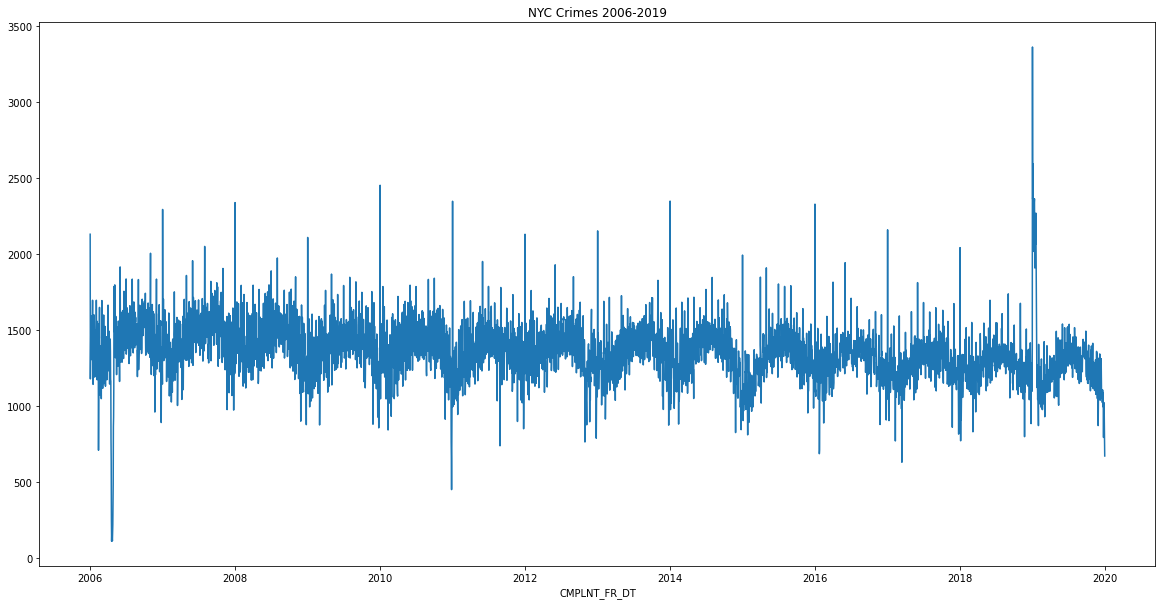

In [5]:
nyc_crime.groupby('CMPLNT_FR_DT').CMPLNT_NUM.count().plot.line(figsize=(20,10), title="NYC Crimes 2006-2019")

In [6]:
rounds = [2, 3, 4]

for r in rounds: 
    print ("Valors únics de Latitud i Longitud arrodonint a", str(r), "decimals:")
    print (len(nyc_crime['Latitude'].round(r).unique()), len(nyc_crime['Longitude'].round(r).unique()))
    fields = ['Latitude', 'Longitude']
    for field in fields: 
        nyc_crime[field+str(r)] = nyc_crime[field].round(r)
    print("Punts únics amb", str(r), "decimals:\n", str(len(nyc_crime.groupby([fields[0]+str(r), fields[1]+str(r)])['CMPLNT_NUM'].count())))

Valors únics de Latitud i Longitud arrodonint a 2 decimals:
43 55
Punts únics amb 2 decimals:
 924
Valors únics de Latitud i Longitud arrodonint a 3 decimals:
416 543
Punts únics amb 3 decimals:
 53397
Valors únics de Latitud i Longitud arrodonint a 4 decimals:
4125 5305
Punts únics amb 4 decimals:
 114686


In [7]:
print("Punts únics amb 6 decimals:\n", str(len(nyc_crime.groupby([fields[0], fields[1]])['CMPLNT_NUM'].count())))

Punts únics amb 6 decimals:
 198349


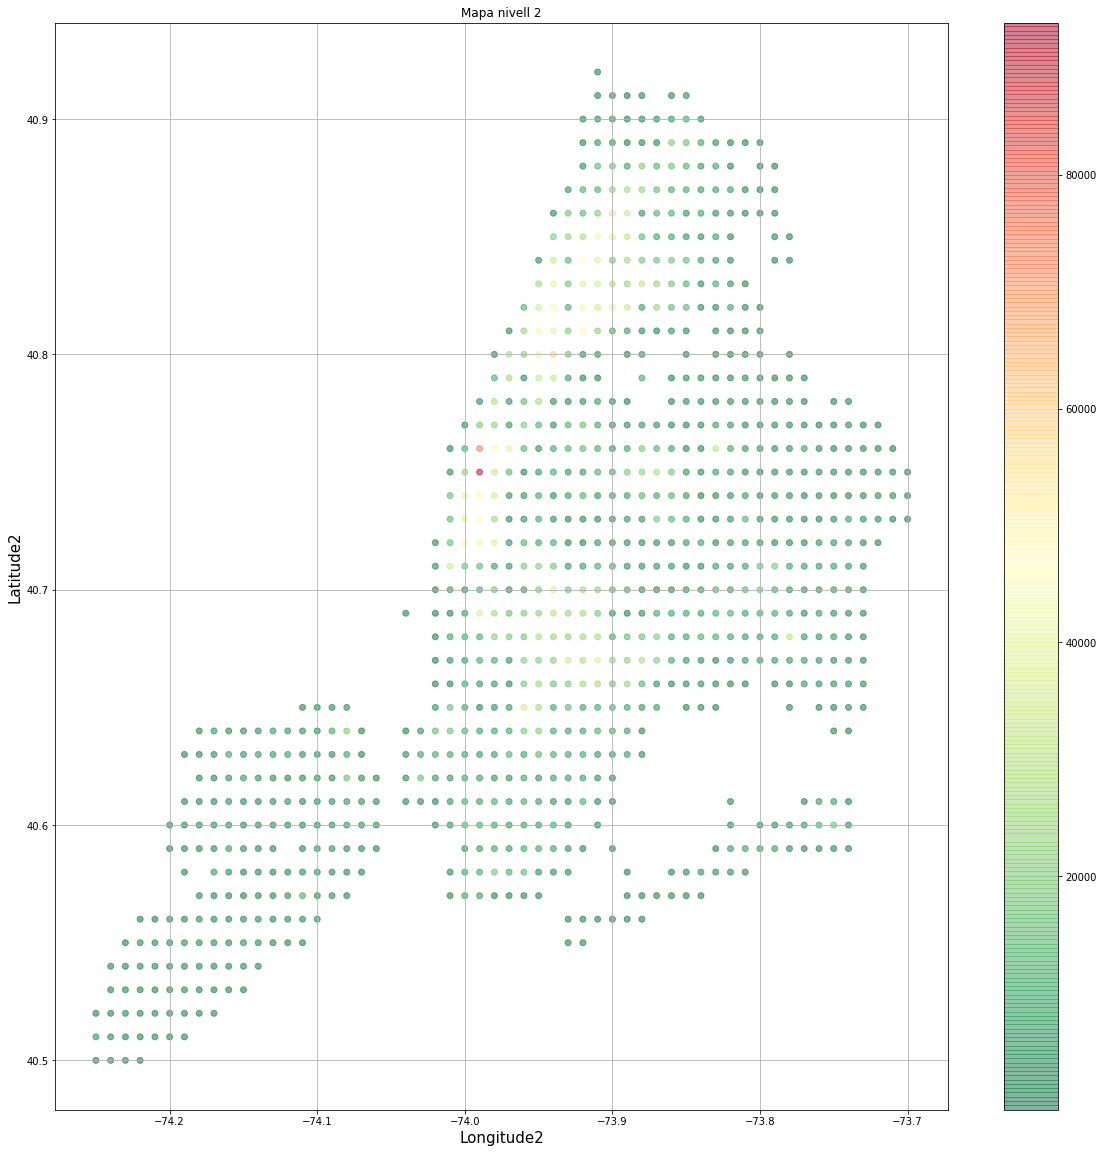

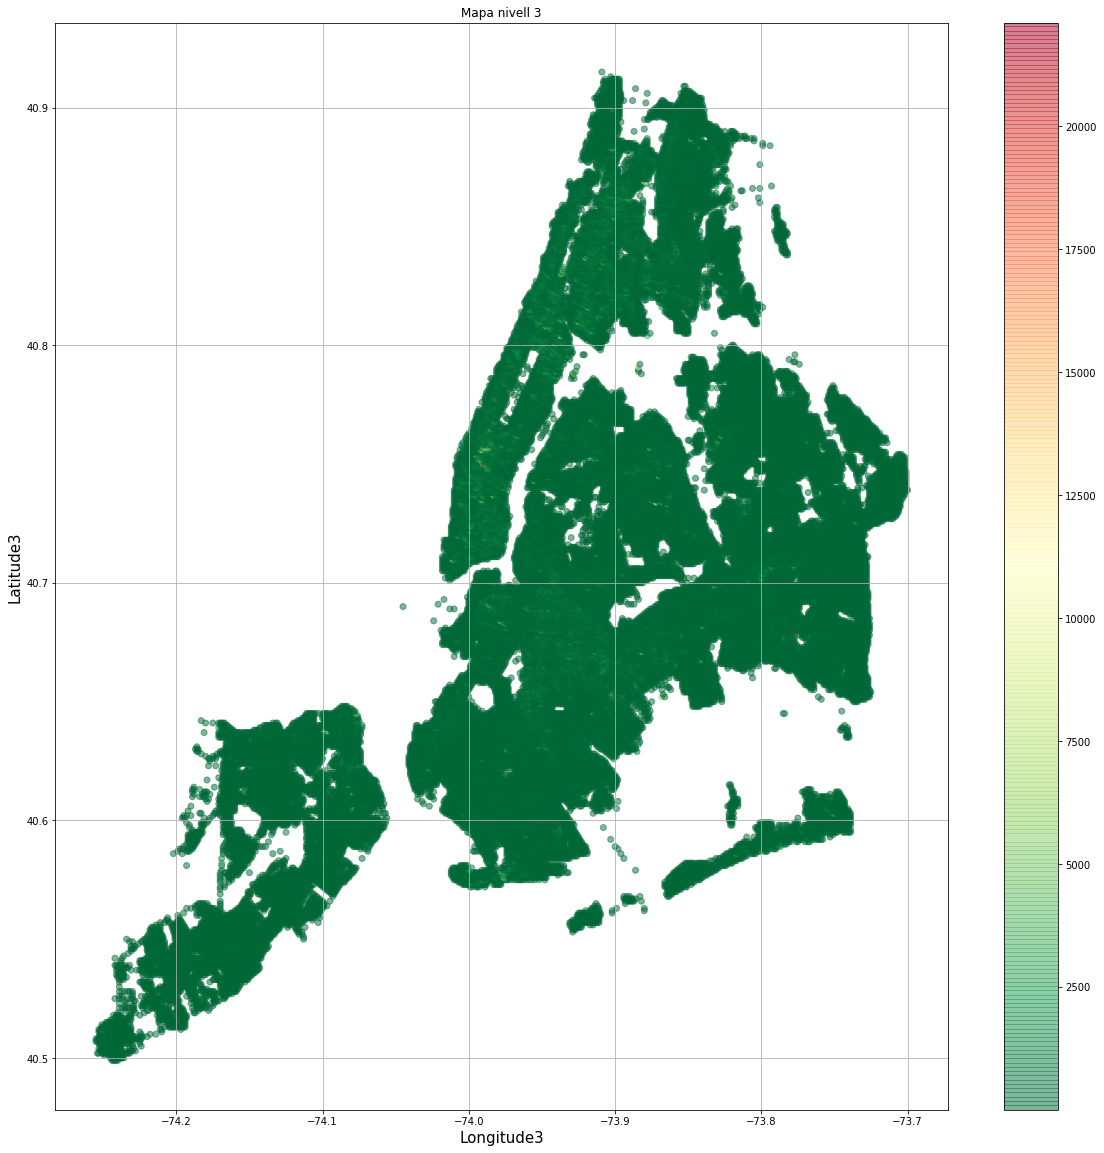

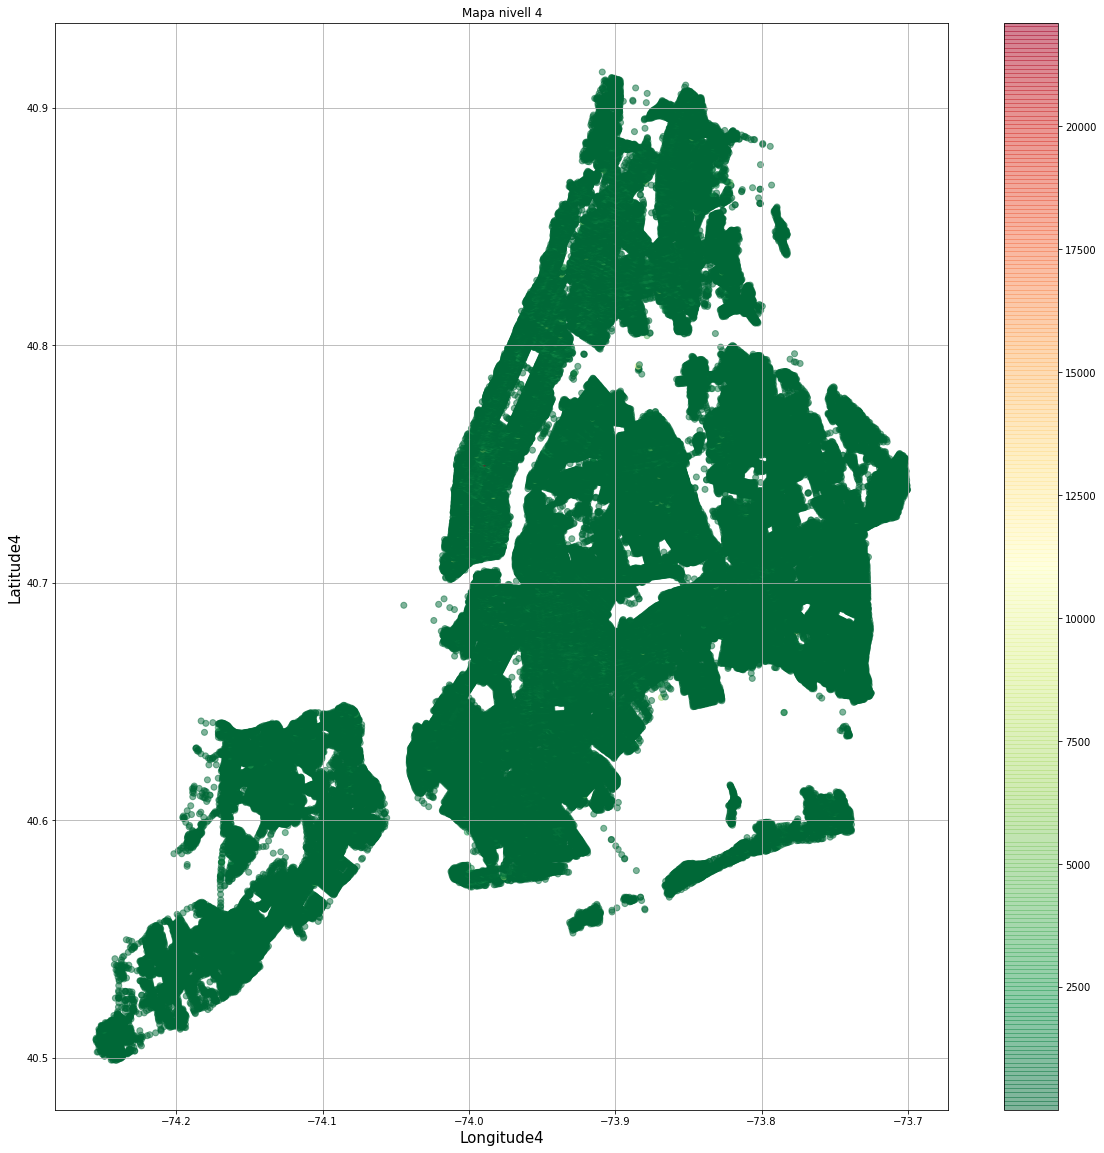

In [8]:
for r in rounds: 
    prov_map_Lat = nyc_crime.groupby(['Latitude'+str(r), 'Longitude'+str(r)]).CMPLNT_NUM.count()
    prov_map_Lat = prov_map_Lat.reset_index()    
    # create data
    fig, ax = plt.subplots()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    cs = ax.scatter(prov_map_Lat['Longitude'+str(r)], prov_map_Lat['Latitude'+str(r)], c= prov_map_Lat.CMPLNT_NUM, cmap='RdYlGn_r', alpha=0.5)
    ax.set_xlabel('Longitude'+str(r), fontsize=15)
    ax.set_ylabel('Latitude'+str(r), fontsize=15)
    ax.set_title('Mapa nivell '+str(r))
    ax.grid(True)
    cbar = fig.colorbar(cs)
    plt.show()

## Selecció de 2 anys    

In [9]:
dataInici = datetime.date(year=2018,month=1,day=1)
dataFi = datetime.date(year=2019,month=12,day=31)

print(len(nyc_crime))
nyc_crime_18_19 = nyc_crime[(nyc_crime['CMPLNT_FR_DT']>=dataInici) & (nyc_crime['CMPLNT_FR_DT']<=dataFi)]
print(len(nyc_crime_18_19))

6950245
937079


# Primera etapa: Predicció diària per districtes 

In [10]:
nyc_district_crime = pd.pivot_table(nyc_crime_18_19, values='CMPLNT_NUM', index='CMPLNT_FR_DT', columns=['PATROL_BORO'], aggfunc='count', fill_value=0)
print (nyc_district_crime.shape)
print ()

(730, 8)


In [11]:
# split into train and test sets
dataIniciTest = datetime.date(year=2019,month=12,day=1)
dataIniciVal = datetime.date(year=2019,month=10,day=1)

train = nyc_district_crime[nyc_district_crime.index<dataIniciVal]
validation = nyc_district_crime[(nyc_district_crime.index>=dataIniciVal) & (nyc_district_crime.index<dataIniciTest)]
test = nyc_district_crime[nyc_district_crime.index>=dataIniciTest]

# normalize the dataset
scaler = MinMaxScaler()
scaler.fit(train)
train_norm = scaler.transform(train)
validation_norm = scaler.transform(validation)
test_norm = scaler.transform(test)

In [12]:
n_input = 7
n_features = len(nyc_district_crime.columns)

trainGenerator = TimeseriesGenerator(train_norm, train_norm, length=n_input, batch_size=1)
validGenerator = TimeseriesGenerator(validation_norm, validation_norm, length=n_input)
testGenerator = TimeseriesGenerator(test_norm, test_norm, length=n_input)

In [13]:
import time
n_epochs = 20

start = time.time() 
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(200))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()
mfit = model.fit_generator(trainGenerator, validation_data=validGenerator, epochs=n_epochs)
L_results= ['New York', mfit]
print ('Temps execució acumulada {} sec\n'.format(time.time() - start))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 200)            167200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1608      
Total params: 489,608
Trainable params: 489,608
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
631/631 [==============================] - 15s 23ms/step - loss: 0.0077 - acc: 0.5468 - val_loss: 0.0040 - val_acc: 0.6852
Epoch 2/20
631/631 [==============================] - 14s 22ms/step - loss: 0.0060 - acc: 0.5737 - val_loss: 0.0048 - val_acc: 0.6852
Epoch 3/20
631/631 [==============================] - 14s 22ms/step - loss: 0.0056 - acc: 0.5911 - val_loss: 0.0044 - val_acc: 0.685

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


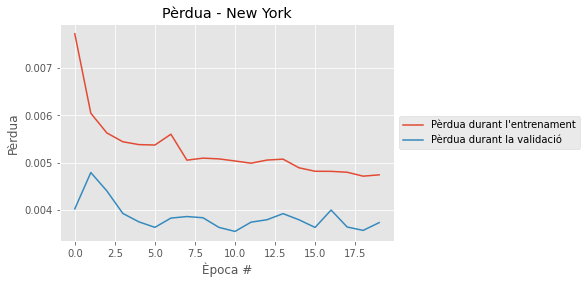

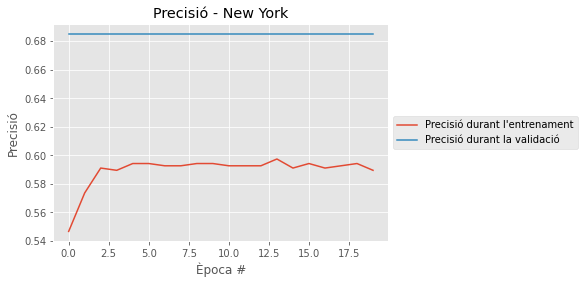

In [18]:
L_results= ['New York', mfit]

plt.style.use("ggplot")
plt.figure()

print (L_results[1].history.keys())
plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[2]], label="Pèrdua durant l'entrenament")
plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[0]], label="Pèrdua durant la validació")
plt.title("Pèrdua - "+L_results[0])
plt.xlabel("Època #")
plt.ylabel("Pèrdua")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()
    
plt.figure()

plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[3]], label="Precisió durant l'entrenament")
plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[1]], label="Precisió durant la validació")
plt.title("Precisió - "+L_results[0])
plt.xlabel("Època #")
plt.ylabel("Precisió")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
predList = []
batch = train_norm[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    predList.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[predList[i]]],axis=1)

In [16]:
predCols = []
for col in nyc_district_crime.columns:
    predCols.append('Prediction_'+str(col))
df_predict = pd.DataFrame(scaler.inverse_transform(predList),
                          index=nyc_district_crime[-n_input:].index, columns=predCols)

df_test = pd.concat([nyc_district_crime,df_predict], axis=1)

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: Ma

rmse:  [22.53885534]


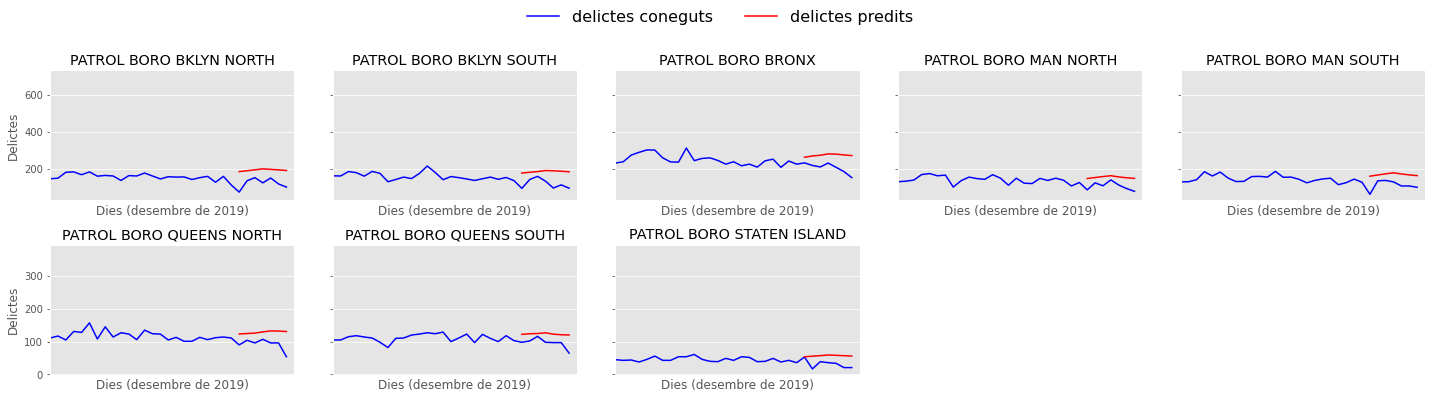

In [25]:
cols = 5 
rows = (len(nyc_district_crime.columns)+cols-1)//cols

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, (2.5*rows)),
                        sharex = 'col', sharey='row',
                        subplot_kw={'xticks': []})

axs = axs.flat
for ax in axs[len(nyc_district_crime.columns):]: 
    ax.remove()
axs = axs[:len(nyc_district_crime.columns)]
i = 0
for col in nyc_district_crime.columns:
    axs[i].plot(df_test.index, df_test[col], color ='b', label = 'delictes coneguts')
    axs[i].plot(df_test.index, df_test['Prediction_'+str(col)], color='r', label = "delictes predits")
    axs[i].set_xlim("2019-12-01", "2020-01-01")
    axs[i].set_title(str(col))
    if (i%cols) == 0: 
        axs[i].set_ylabel("Delictes")    
    axs[i].set_xlabel("Dies (desembre de 2019)")    
    i = i+1 

lines, labels = fig.axes[-1]. get_legend_handles_labels()   
plt.figlegend(lines, labels, loc = 'lower center', ncol = 2, fontsize = 16,
              frameon = False, bbox_to_anchor=(0.5, 1) )
plt.tight_layout()

pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

In [19]:
nyc_district_crime.mean()

PATROL_BORO
PATROL BORO BKLYN NORTH      188.431507
PATROL BORO BKLYN SOUTH      185.258904
PATROL BORO BRONX            280.575342
PATROL BORO MAN NORTH        155.545205
PATROL BORO MAN SOUTH        164.275342
PATROL BORO QUEENS NORTH     131.302740
PATROL BORO QUEENS SOUTH     122.175342
PATROL BORO STATEN ISLAND     55.272603
dtype: float64